### Submission by **Group 29**
- Adi Tsach (SCIPER: 375887)
- Maximilian Müller (SCIPER: 376293)

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
#Useful imports: 
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Operator
from qiskit import *
import numpy as np
from qiskit import QuantumCircuit, execute, BasicAer
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import I, Z, X

import matplotlib.pyplot as plt
%matplotlib inline

 ## 3.1 Generate a random unitary U by generating a random circuit over $n=5$ qubits with depth$=3$
 You may use Qiskit's built-in function for random circuits: https://qiskit.org/documentation/stable/0.19/stubs/qiskit.circuit.random.random_circuit.html. 
 Visualize your random circuit using **draw(output='mpl')**.

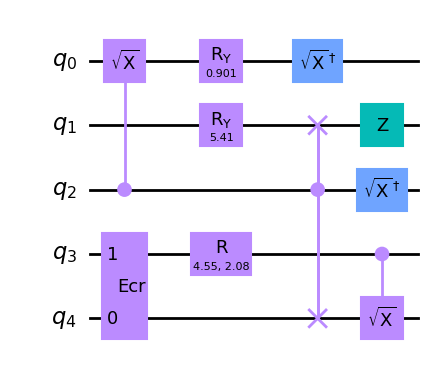

In [3]:
U = random_circuit(5, 3)
U.draw(output='mpl')

## 3.2 Compute the trace of the generated random unitary classically. 
For a circuit U, you may use **Operator(U).data** to convert U into a numpy array.

In [4]:
x = Operator(U).data
classicalTrace = x.trace()
classicalTrace

(-1.4679919124816028-0.07662442211658582j)

## 3.3 Build the circuit for estimating the real part of the trace of U. 
Hint: you may find the following useful: 
**.to_gate()** : https://qiskit.org/documentation/stable/0.39/stubs/qiskit.circuit.QuantumCircuit.to_gate.html

**.control(..)**: https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html

**.append(..)**: https://qiskit.org/documentation/stable/0.19/stubs/qiskit.circuit.QuantumCircuit.append.html

In [5]:
qc1 = QuantumCircuit(11, 1)
qc1.h(0)

for i in range(1,6):
    qc1.h(i)
    qc1.cx(i, i+5)
    
GateU = U.to_gate().control()
qc1.append(GateU, [0,1,2,3,4,5])
qc1.h(0)
_ = qc1.measure(0, 0)

#### Draw your estimation circuit: 

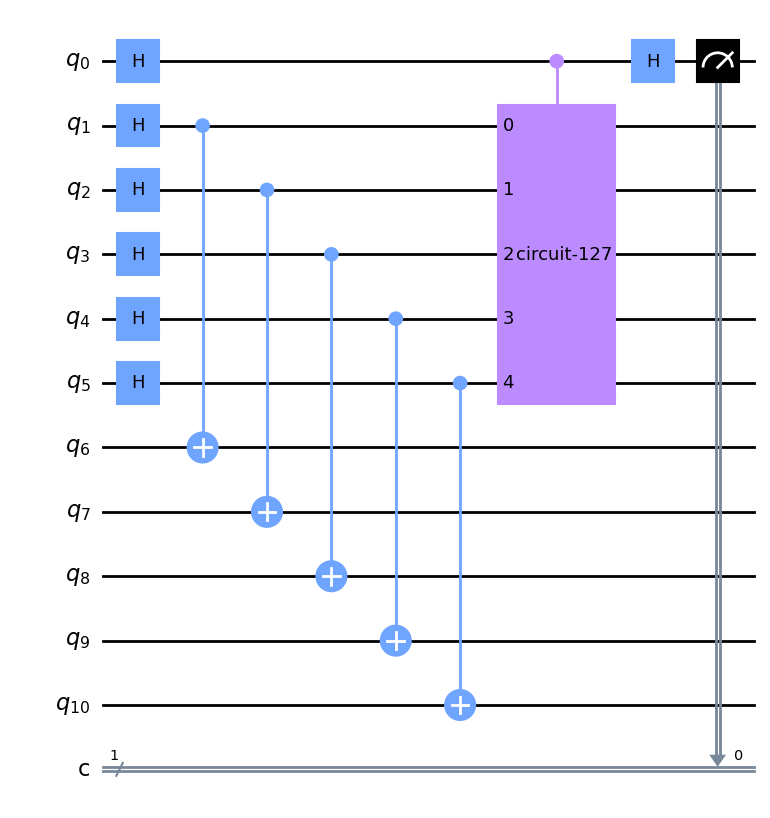

In [6]:
qc1.draw('mpl')

#### Run your circuit using the 'qasm_simulator'.
Compute the estimate of the trace of the real part from the circuit results.
Compare your estimate with the one computed in question 3.2.
You may change the number of shots till you obtain an accurate result.

In [13]:
backend = service.backend('ibmq_qasm_simulator')
options = Options()
options.execution.shots = 10000000

sampler = Sampler(options=options, backend=backend)
job = sampler.run(circuits=qc1)
result = job.result()

estimationReal = (1 << 6) * (result.quasi_dists[0].get(0) - 0.5)
print("estimated: " + str(estimationReal))
print("  correct: " + str(classicalTrace.real))

base_primitive._run_primitive:INFO:2023-12-21 09:23:32,916: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 10000000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


estimated: -1.4783359999999988
  correct: -1.4679919124816028


## 4.1 Generate the unitary $U_{\text{mystery}} = e^{i\theta (X\otimes X)}$ for $\theta = \pi/3$.
Hint: use https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliEvolutionGate.html 

In [8]:
operator0 = (X.tensor(X))
evo0 = PauliEvolutionGate(operator0, time=(2*np.pi) - (1/3*np.pi)) # Pauli is e^(-i * theta * A)
Operator(evo0.definition).data

array([[0.5+0.j       , 0. +0.j       , 0. +0.j       , 0. +0.8660254j],
       [0. +0.j       , 0.5+0.j       , 0. +0.8660254j, 0. +0.j       ],
       [0. +0.j       , 0. +0.8660254j, 0.5+0.j       , 0. +0.j       ],
       [0. +0.8660254j, 0. +0.j       , 0. +0.j       , 0.5+0.j       ]])

## 4.2 Vary $\theta$ from 0 to $\pi/2$. For each value, generate the estimation circuit for the real part of the trace of $U_{\text{mystery}}$.
Run your circuit using the Qiskit simulator. Make a plot: on the x-axis: $\theta$ from 0 to $\pi/2$, and on the y-axis: your obtained estimate for $\theta$ . 

In [9]:
def qc_theta(theta):
    operator0 = (X.tensor(X))
    evo0 = PauliEvolutionGate(operator0, time=theta) # works because cos(-theta) = cos(theta)

    qc2 = QuantumCircuit(5, 1)
    qc2.h(0)

    qc2.h(1)
    qc2.cx(1, 3)
    qc2.h(2)
    qc2.cx(2, 4)

    GateE0 = evo0.control()
    qc2.append(GateE0, [0,1,2])
    qc2.h(0)
    qc2.measure(0, 0)
    return qc2

phases = np.linspace(0, np.pi / 2, 12)

backend2 = service.backend('ibmq_qasm_simulator')
options2 = Options()
options2.execution.shots = 1000

sampler2 = Sampler(options=options2, backend=backend2)

def estimate_theta(theta):
    qc2 = qc_theta(theta)
    job2 = sampler2.run(
        circuits=[qc2]
    )
    result2 = job2.result()
    return np.arccos(2 * (result2.quasi_dists[0].get(0,0) - 0.5))

results2 = [estimate_theta(theta) for theta in phases]

base_primitive._run_primitive:INFO:2023-12-21 09:19:48,380: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-12-21 09:19:53,219: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans

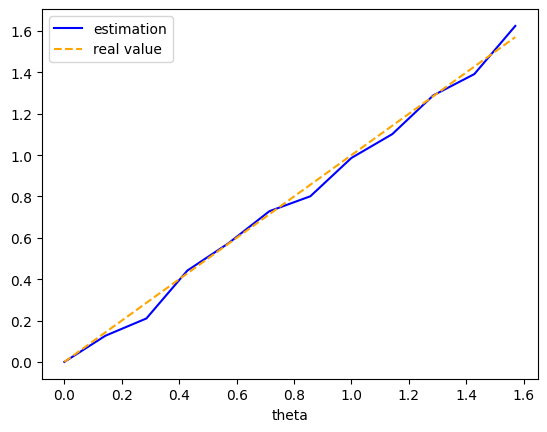

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(phases, results2, color="blue", label="estimation")
ax.plot(phases, phases, color="orange", linestyle="dashed", label="real value")
ax.set(xlabel="theta")
ax.legend()
fig.show()
#fig.savefig('theta.png')

## 5.3 Take the circuit generated in 3.1. For different values of $k$, run the trace estimation circuit $k$ number of shots and compute 1) the single value estimate of the real part of the trace of U and 2) the CI you got in the exercise 5.2 at level $95\%$



In [11]:
backend3 = service.backend('ibmq_qasm_simulator')

def runQc1Times(shots):
    options3 = Options()
    options3.execution.shots = shots

    sampler3 = Sampler(options=options3, backend=backend3)
    job3 = sampler3.run(circuits=qc1)
    result3 = job3.result()

    pHat = result3.quasi_dists[0].get(0)
    plusMinus = (1 << 6) * 1.96 * np.sqrt(pHat * (1-pHat) / shots)
    expectationM = (1 << 6) * (pHat - 0.5)
    return (expectationM, expectationM - plusMinus, expectationM + plusMinus)

phases3 = np.logspace(3, 6, num=8, base=10)
results3 = [runQc1Times(times) for times in phases3]

base_primitive._run_primitive:INFO:2023-12-21 09:20:37,506: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 1000.0, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-12-21 09:20:41,211: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_tra

## Plot the true real part of the trace, the single-value estimate of it, and the CI against $k$. 

For drawing CIs, you can use https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html

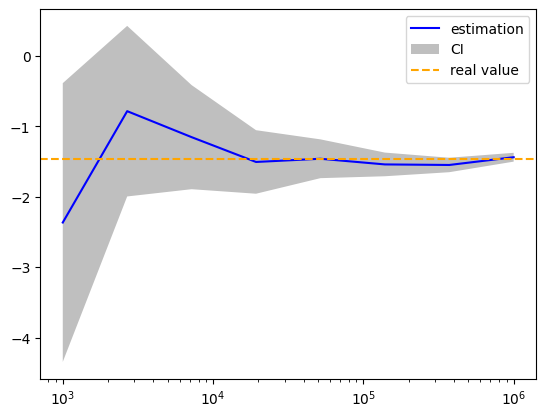

In [12]:
estimations = [ests for (ests, x2, x3) in results3]
lowers = [lower for (x1, lower, x2) in results3]
uppers = [upper for (x1, x2, upper) in results3]

fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.plot(phases3, estimations, color="blue", label="estimation")
ax.fill_between(phases3, lowers, uppers, alpha=0.5, facecolor="grey", label="CI")

ax.axhline(classicalTrace.real, color="orange", linestyle="dashed", label="real value")

ax.legend()

fig.show()
#fig.savefig("random-ci.png")